# Read me

- If you are testing the additive model noise, make sure that line 58 of new_dataloading is Database = f_sum(Database)  
- If you are testing the additive model noise, make sure that line 58 of new_dataloading is Database = f_sum2(Database)  
- Section "Comparison between real and estimated covariance" is to be used only in the multiplicative noise case

# Data retrieval

In [38]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from scipy.stats import t
print(torch.cuda.device_count())
print(os.getcwd())
import statsmodels

1
/home/VM-Nicolas-Lafon/These/4Dvarnetstochastic/Autoregressive_model


In [41]:
ncfile = Dataset('Results/Bestmodel-multiplicative_noise-flagInit2.nc')
print(ncfile)
mu = ncfile['mean_pred']
cov = ncfile['cov_pred']
init = ncfile['inits']
target = ncfile['targets']


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): Nb_samples(200), time(10), x(30)
    variables(dimensions): float32 mean_pred(Nb_samples, time, x), float32 cov_pred(Nb_samples, time, x), float32 inits(Nb_samples, time, x), float32 targets(Nb_samples, time, x), float64 Nb_samples(Nb_samples), float64 time(time), float64 space(x)
    groups: 


# First visualization

3.5006475
0.05085188
5.656299
Mean precision for each timestep
[448.11124 522.1083  475.79517 492.8147  509.65244 499.44016 463.00403
  35.27819  28.59308  25.85047]
Mean covariance for each timestep
[0.00223159 0.00191531 0.00210174 0.00202916 0.00196212 0.00200224
 0.00215981 0.02834613 0.03497349 0.03868402]


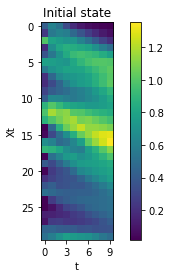

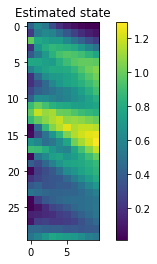

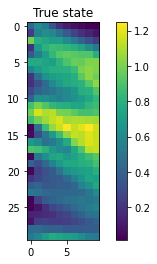

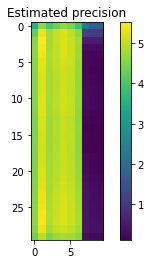

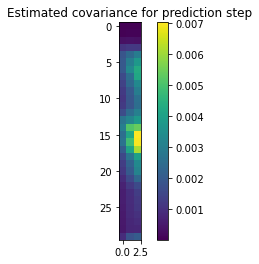

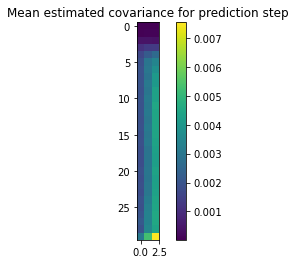

In [42]:
plt.figure()
plt.title('Initial state')
plt.ylabel('Xt')
plt.yticks(np.arange(0,31,5))
plt.xlabel('t')
plt.xticks(np.arange(0,10,3))
plt.imshow(np.transpose(init[10,:,:]))
plt.colorbar()
plt.figure()
plt.title('Estimated state')
plt.imshow(np.transpose(mu[10,:,:]))
plt.colorbar()
plt.figure()
plt.title('True state')
plt.imshow(np.transpose(target[10,:,:]))
plt.colorbar()
plt.figure()
plt.title('Estimated precision')
plt.imshow(np.transpose(np.abs(cov[10,:,:])))
plt.colorbar()
plt.figure()
plt.title('Estimated covariance for prediction step')
plt.imshow((1/100*np.transpose(1/np.abs(cov[10,7:10,:])))**2)
plt.colorbar()
plt.figure()
plt.title('Mean estimated covariance for prediction step')
plt.imshow(np.transpose((1/100*np.mean(1/np.abs(cov[:,7:10,:]),0))**2))
plt.colorbar()
print(np.mean(np.abs(cov)))
print(np.min(np.abs(cov)))
print(np.max(np.abs(cov)))
print("Mean precision for each timestep")
print(np.mean(np.mean(np.abs(cov),0),1)*100)
print("Mean covariance for each timestep")
print(1/(np.mean(np.mean(np.abs(cov),0),1)*100))

Mean square error between estimated mean state and true state for each timestep
[9.5743519e-07 1.0178723e-06 9.8763132e-07 1.0258968e-06 1.0079860e-06
 1.0177166e-06 1.0021571e-06 1.2740951e-03 2.0387904e-03 2.7806754e-03]
Mean square error between initial condition and true state for prediction step
[0.00174993 0.00326032 0.0045301 ]


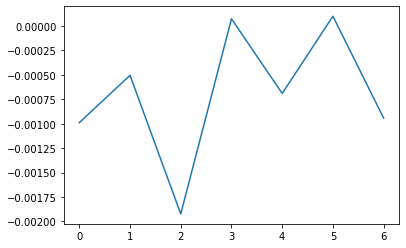

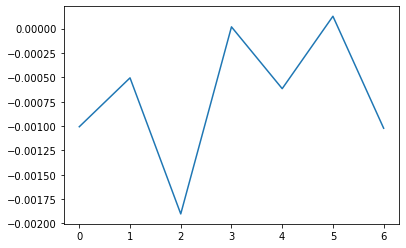

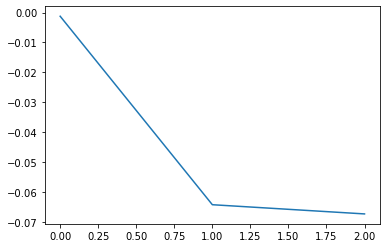

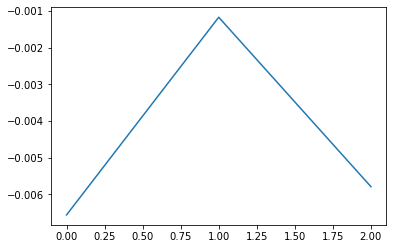

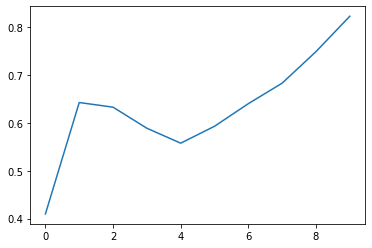

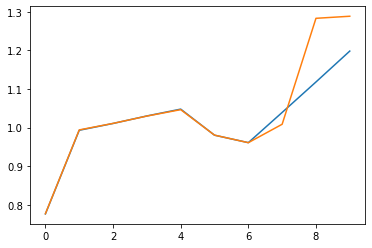

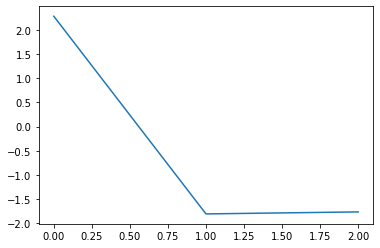

In [39]:

plt.plot(init[10,0:7,10]-target[10,0:7,10])
plt.figure()
plt.plot(mu[10,0:7,10]-target[10,0:7,10])
plt.figure()
plt.plot(init[10,7:10,11]-target[10,7:10,11])
plt.figure()
plt.plot(mu[10,7:10,10]-target[10,7:10,10])
plt.figure()
plt.plot(mu[10,:,10])
plt.figure()
plt.plot(mu[50,:,10])
plt.plot(target[50,:,10])
plt.figure()
plt.plot(cov[0,7:10,0])

print("Mean square error between estimated mean state and true state for each timestep")
print(np.mean(np.mean((mu[:,:,:]-target[:,:,:])**2,0),1))

print("Mean square error between initial condition and true state for prediction step")
print(np.mean(np.mean((init[:,7:10,:]-target[:,7:10,:])**2,0),1))

# Comparison between real and estimated covariance

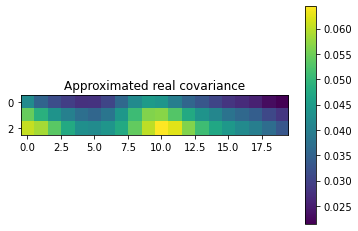

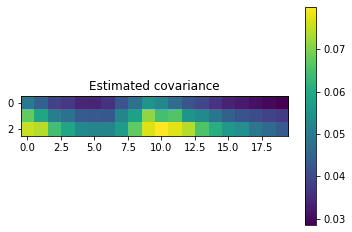

In [40]:
#ONLY for the multiplicative noise experiment

DX = 30
indice = 5
Model_noise =0.02
Obs_noise = 0.001
real_cov = torch.zeros(10,30)
real_cov[0:7,:]=Obs_noise
for i in range(7,10):
    for j in range(30):
        real_cov[i,j] = (0.6*real_cov[i-1,j])**2+(0.4*real_cov[i-1,(j-1)%DX])**2+(0.2*real_cov[i-1 , (j+1)%DX])**2+(0.1*real_cov[i-1,(j+2)%DX])**2+(0.05*real_cov[i-1, (j-2)%DX])**2
        real_cov[i,j] += (target[indice,i-1,j]+target[indice,i-1,(j-1)%DX])**2*(0.02**2)
        real_cov[i,j] =np.sqrt(real_cov[i,j])



estimated_cov = 1/np.abs(cov[indice,:,:])/100


plt.figure()
plt.title("Approximated real covariance")
plt.imshow(real_cov[7:10,5:25])
plt.colorbar()
plt.figure()
plt.title("Estimated covariance")
plt.imshow(estimated_cov[7:10,5:25])
plt.colorbar()

# Opérateur dynamique

In [25]:
from models import Gradient_img, LitModel
import torch

In [26]:
ckpt_path ='Results/Bestmodel-additive_noise.ckpt'
lit_cls = LitModel
mod = lit_cls.load_from_checkpoint(ckpt_path, 
                                                    mean_Tr=0, 
                                                    std_Tr = 0
                                                    )

Phi_r(
  (encoder): Encoder(
    (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (convTr): ConvTranspose2d(10, 10, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (NNLR): Sequential(
      (0): BiLinUnit(
        (conv1): Conv2d(10, 100, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (conv2): Conv2d(100, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv3): Conv2d(100, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bilin0): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bilin1): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bilin2): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (NNHR): Sequential(
      (0): BiLinUnit(
        (conv1): Conv2d(10, 100, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)


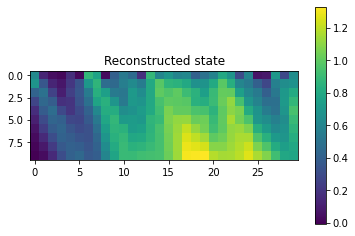

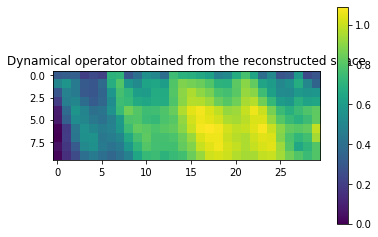

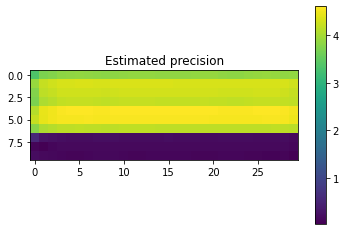

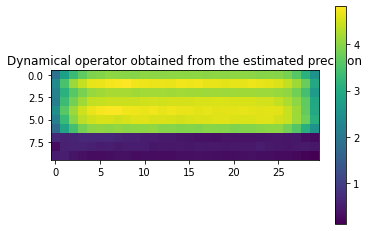

In [26]:
print(mod.model.phi_r)
ex= torch.zeros(1,10,30,2)
print(ex.shape)
ex[0,:,:,0] = torch.Tensor(mu[100,:,:])
ex[0,:,:,1] = torch.Tensor(cov[100,:,:])
i0 = mod.model.phi_r(ex).detach().numpy()
plt.figure()
plt.title("Reconstructed state")
plt.imshow(ex[0,:,:,0])
plt.colorbar()
plt.figure()
plt.title("Dynamical operator obtained from the reconstructed space")
plt.imshow(i0[0,:,:,0])
plt.colorbar()
plt.figure()
plt.title("Estimated precision")
plt.imshow(np.abs(ex[0,:,:,1]))
plt.colorbar()
plt.figure()
plt.title("Dynamical operator obtained from the estimated precision")
plt.imshow(np.abs(i0[0,:,:,1]))
plt.colorbar()


 # Scoring rules

We focus on P-score : 

In [29]:
def logarithmic_scores(t,mu,sig):
    return(0.5*(((t-mu)*sig*100)**2)-np.log(sig*100)+0.5*np.log(2*np.pi))


scores = logarithmic_scores(target[:,:,:],mu[:,:,:],np.abs(cov[:,:,:]))

In [30]:
print("Mean P-score for each timestep")
print(np.mean(np.mean(scores[:,:,:],0),1))

Mean P-score for each timestep
[-5.088992940266928 -5.199369852701822 -5.13373607381185
 -5.156059438069661 -5.183628743489583 -5.167294881184897
 -5.110535522460938 -2.0611654001871744 -1.8445635579427087
 -1.7087711385091144]
